<h1>Predictive Maintenance Using LSTM and GRU on NASA Turbofan Engine Dataset</h1>

<h1>Data Preprocessing</h1>

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras

np.random.seed(1234)
PYTHONHASHSEED = 0

# Load the data
train_data = pd.read_csv('train_FD001.txt', sep='\s+', header=None)
train_data.columns = ['id', 'cycle'] + [f'operational_setting_{i}' for i in range(1, 4)] + [f'sensor_{i}' for i in range(1, 22)]
train_data = train_data.drop(columns=['sensor_22', 'sensor_23'], errors='ignore')

test_data = pd.read_csv('test_FD001.txt', sep='\s+', header=None)
test_data.columns = ['id', 'cycle'] + [f'operational_setting_{i}' for i in range(1, 4)] + [f'sensor_{i}' for i in range(1, 22)]
test_data = test_data.drop(columns=['sensor_22', 'sensor_23'], errors='ignore')

rul_data = pd.read_csv('RUL_FD001.txt', header=None) 

#######
# TRAIN
#######

#calculate maximum cycle value
rul = train_data.groupby('id')['cycle'].max().reset_index()

#Rename the columns
rul.columns = ['id', 'max_cycle']

#Merge the rul DataFrame
train_df = train_data.merge(rul, on=['id'], how='left')

# Calculate the Remaining Useful Life (RUL)
train_df['RUL'] = train_df['max_cycle'] - train_df['cycle']

#Removing max_cycle
train_df= train_df.drop(['max_cycle'],axis=1)

w1 = 30
w0 = 15

train_df['label1'] = train_df['RUL'].apply(lambda x: 1 if x <= w1 else 0)
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

train_df['cycle_norm'] = train_df['cycle'] / train_df.groupby('id')['cycle'].transform('max')
cols_normalize = train_df.columns.difference(['id', 'cycle', 'RUL', 'label1', 'label2'])

#MinMaxScaler
min_max_scaler = MinMaxScaler()

# MinMaxScaler
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_data.index)
if 'cycle_norm' in norm_train_df.columns:
    norm_train_df = norm_train_df.drop(columns=['cycle_norm'])
join_df = train_df[['id', 'cycle', 'RUL', 'label1', 'label2', 'cycle_norm']].join(norm_train_df)
train_df = join_df.reindex(columns=train_data.columns.tolist() + ['RUL', 'label1', 'label2', 'cycle_norm'])

In [2]:
######
# TEST
######

# MinMax normalization (from 0 to 1)
test_data['cycle_norm'] = test_data['cycle'] / test_data.groupby('id')['cycle'].transform('max')

norm_test_df = pd.DataFrame(min_max_scaler.transform(test_data[cols_normalize]), columns=cols_normalize, index=test_data.index)

if 'cycle_norm' in norm_test_df.columns:
    norm_test_df = norm_test_df.drop(columns=['cycle_norm'])

test_join_df = test_data[['id', 'cycle', 'cycle_norm']].join(norm_test_df)
test_df = test_join_df.reindex(columns=test_data.columns.tolist() + ['cycle_norm'])

# RUL from test_data
rul = test_df.groupby('id')['cycle'].max().reset_index()
rul.columns = ['id', 'max']

truth_df = pd.DataFrame(rul_data)
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1

rul = test_df.groupby('id')['cycle'].max().reset_index()
rul.columns = ['id', 'max']

truth_df['max'] = rul['max'] + truth_df['more']

# Merging
test_df = test_df.merge(truth_df[['id', 'max']], on='id', how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop(['max'], axis=1, inplace=True)

test_df['label1'] = test_df['RUL'].apply(lambda x: 1 if x <= w1 else 0)
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

<h2>Feature Engineering</h2>

In [3]:
# Exponenetial Moving Average (Gives more wieght to recent data points)
window_size = 3
for col in train_data.columns:
    train_data[f'{col}_ema'] = train_data.groupby('id')[col].transform(lambda x: x.ewm(span=window_size, adjust=False).mean())
    test_data[f'{col}_ema'] = test_data.groupby('id')[col].transform(lambda x: x.ewm(span=window_size, adjust=False).mean())

# Print output of exponential moving averages
print("Train data with exponential moving averages (first few rows):")
print(train_data[[col for col in train_data.columns if '_ema' in col]].head())

Train data with exponential moving averages (first few rows):
   id_ema  cycle_ema  operational_setting_1_ema  operational_setting_2_ema  \
0     1.0     1.0000                  -0.000700                  -0.000400   
1     1.0     1.5000                   0.000600                  -0.000350   
2     1.0     2.2500                  -0.001850                  -0.000025   
3     1.0     3.1250                  -0.000575                  -0.000013   
4     1.0     4.0625                  -0.001237                  -0.000106   

   operational_setting_3_ema  sensor_1_ema  sensor_2_ema  sensor_3_ema  \
0                      100.0        518.67    641.820000    1589.70000   
1                      100.0        518.67    641.985000    1590.76000   
2                      100.0        518.67    642.167500    1589.37500   
3                      100.0        518.67    642.258750    1586.08250   
4                      100.0        518.67    642.314375    1584.46625   

   sensor_4_ema  sensor_

In [4]:
#Lag Features
n_lags = 3 
for col in train_data.columns:
    if col != 'id':
        for lag in range(1, n_lags + 1):
            train_data[f'{col}_lag_{lag}'] = train_data.groupby('id')[col].shift(lag)
            test_data[f'{col}_lag_{lag}'] = test_data.groupby('id')[col].shift(lag)

# Fill NaN values that are created due to shifting
train_data.fillna(0, inplace=True)
test_data.fillna(0, inplace=True)

# Print output of lag features
print("Train data with lag features (first few rows):")
print(train_data[[col for col in train_data.columns if '_lag_' in col]].head())

C:\Users\parth\AppData\Local\Temp\ipykernel_16500\638462982.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_data[f'{col}_lag_{lag}'] = test_data.groupby('id')[col].shift(lag)
C:\Users\parth\AppData\Local\Temp\ipykernel_16500\638462982.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_data[f'{col}_lag_{lag}'] = test_data.groupby('id')[col].shift(lag)
C:\Users\parth\AppData\Local\Temp\ipykernel_16500\638462982.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

Train data with lag features (first few rows):
   cycle_lag_1  cycle_lag_2  cycle_lag_3  operational_setting_1_lag_1  \
0          0.0          0.0          0.0                       0.0000   
1          1.0          0.0          0.0                      -0.0007   
2          2.0          1.0          0.0                       0.0019   
3          3.0          2.0          1.0                      -0.0043   
4          4.0          3.0          2.0                       0.0007   

   operational_setting_1_lag_2  operational_setting_1_lag_3  \
0                       0.0000                       0.0000   
1                       0.0000                       0.0000   
2                      -0.0007                       0.0000   
3                       0.0019                      -0.0007   
4                      -0.0043                       0.0019   

   operational_setting_2_lag_1  operational_setting_2_lag_2  \
0                       0.0000                       0.0000   
1        

In [5]:
# Fill NaN values with column means
sensor_columns = [col for col in train_data.columns if 'sensor_' in col]
train_data[sensor_columns] = train_data[sensor_columns].fillna(train_data[sensor_columns].mean())
test_data[sensor_columns] = test_data[sensor_columns].fillna(train_data[sensor_columns].mean())

In [6]:
train_data.isna().sum()

id                       0
cycle                    0
operational_setting_1    0
operational_setting_2    0
operational_setting_3    0
                        ..
sensor_20_ema_lag_2      0
sensor_20_ema_lag_3      0
sensor_21_ema_lag_1      0
sensor_21_ema_lag_2      0
sensor_21_ema_lag_3      0
Length: 205, dtype: int64

In [7]:
#Performing PCA
cols_to_scale = [col for col in train_data.columns if 'sensor_' in col]

# Standardize the data
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_data[cols_to_scale])
scaled_test = scaler.transform(test_data[cols_to_scale])

pca = PCA(n_components=10)
pca_train = pca.fit_transform(scaled_train)
pca_test = pca.transform(scaled_test)
print("Variance:")
print(pca.explained_variance_ratio_)
print("PCA:")
print(pd.DataFrame(pca_train).head())

#Integrating PCA componenets into DF
pca_columns = [f'PCA_{i+1}' for i in range(pca_train.shape[1])]
pca_train_df = pd.DataFrame(pca_train, columns=pca_columns)
pca_test_df = pd.DataFrame(pca_test, columns=pca_columns)

train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)
pca_train_df.reset_index(drop=True, inplace=True)
pca_test_df.reset_index(drop=True, inplace=True)
train_data = pd.concat([train_data, pca_train_df], axis=1)
test_data = pd.concat([test_data, pca_test_df], axis=1)

Variance:
[0.64733287 0.12677561 0.11621958 0.04314795 0.02722752 0.01121303
 0.00368463 0.00324423 0.00306248 0.00264159]
PCA:
            0          1          2          3         4         5         6  \
0  121.172410 -14.025641 -29.437439   3.803957 -0.129321 -0.691995 -1.269948   
1   70.570732  16.013908  38.792412 -20.123706 -0.742806 -0.817989 -1.314567   
2   30.363888  15.068706  27.359151  31.089210 -0.187450 -0.988355 -0.912612   
3   -0.812184   4.362749  -2.074345  -0.132694 -1.162976 -0.549554  0.239642   
4   -0.824468   3.498058  -1.746688  -0.149959 -0.704272 -0.520935  0.776547   

          7         8         9  
0  1.054545 -0.586803  0.115203  
1  0.463737 -0.227724 -0.287371  
2 -1.060987 -0.633613  0.090833  
3 -0.155844  0.037484 -0.153259  
4  0.357746  0.055997 -0.571047  


<h1>Model Building</h1>

<h2>LSTM</h2>

In [8]:
sequence_length = 50 

# Function to reshape features into (samples, time steps, features)
def generate_sequences(id_df, sequence_length, feature_columns):
    data_matrix = id_df[feature_columns].values
    num_elements = data_matrix.shape[0]

    # Generate sequences
    for start in range(num_elements):
        end = start + sequence_length
        if end <= num_elements:
            seq = data_matrix[start:end, :]
            yield seq
        else:
            seq = data_matrix[start:num_elements, :]
            padding = np.zeros((sequence_length - seq.shape[0], data_matrix.shape[1]))
            seq = np.vstack((seq, padding))
            yield seq

# feature columns for sequence generation
sensor_columns = [col for col in train_df.columns if 'sensor_' in col]
sequence_columns = ['operational_setting_1', 'operational_setting_2', 'operational_setting_3'] + sensor_columns

sequence_list = []
for id in train_df['id'].unique():
    id_df = train_df[train_df['id'] == id]
    sequences = list(generate_sequences(id_df, sequence_length, sequence_columns))
    sequence_list.extend(sequences)

# TODO: Convert generated sequences to a numpy array for LSTM input
sequence_array = np.array(sequence_list)
#print("Sequence array shape:", sequence_array.shape)

# TODO: Function to generate labels
def generate_labels(id_df, sequence_length, label_column):
    """Generate labels for a given id."""
    data_array = id_df[label_column].values
    num_elements = data_array.shape[0]
    labels = []
    for start in range(num_elements):
        end = start + sequence_length
        if end <= num_elements:
            label = data_array[end - 1]
        else:
            label = data_array[-1]
        labels.append(label)
    return labels

# TODO: Generate labels for all engine ids in the training data
label_list = []
for id in train_df['id'].unique():
    id_df = train_df[train_df['id'] == id]
    labels = generate_labels(id_df, sequence_length, 'label1')
    label_list.extend(labels)

# TODO: Convert labels to a numpy array
label_array = np.array(label_list)
label_array = label_array.reshape(-1, 1)
print("Label array shape:", label_array.shape)

Label array shape: (20631, 1)


In [9]:
nb_features = sequence_array.shape[2]
nb_out = label_array.shape[1]
units_1 = 16
units_2 = 8

params_LSTM1 = 4 * units_1 * (units_1 + nb_features + 1)
params_LSTM2 = 4 * units_2 * (units_2 + units_1 + 1)
params_Dense = units_2 * nb_out + nb_out
total_params = params_LSTM1 + params_LSTM2 + params_Dense

if total_params > 10000:
    raise ValueError("Total parameters exceed 10,000. Adjust the number of units.")

#Sequential Model
model = Sequential()

#LSTM-1stLayer
model.add(LSTM(
    units=units_1,
    return_sequences=True,
    input_shape=(sequence_length, nb_features)
))
model.add(Dropout(0.2))

#LSTM-2ndLayer
model.add(LSTM(
    units=units_2,
    return_sequences=False
))
model.add(Dropout(0.2))

#Sigmoid Activation
model.add(Dense(units=nb_out, activation='sigmoid'))

#Binary cross Entropt loss - Adam Optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

C:\Users\parth\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 16)         │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 8)              │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,433 (13.41 KB)

 Trainable params: 3,433 (13.41 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
lstm = model.fit(
    sequence_array,
    label_array,
    epochs=50,            
    batch_size=200,       
    #validation split 10%
    validation_split=0.1, 
    verbose=1,
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            min_delta=0.0001,
            patience=5,
            verbose=1,
            mode='min'
        ),
        ModelCheckpoint(
            filepath='best_model.keras',
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            verbose=1
        )
    ]
)

Epoch 1/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6526 - loss: 0.5879
Epoch 1: val_loss improved from inf to 0.30476, saving model to best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6555 - loss: 0.5858 - val_accuracy: 0.9317 - val_loss: 0.3048
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9451 - loss: 0.2708
Epoch 2: val_loss improved from 0.30476 to 0.15762, saving model to best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9452 - loss: 0.2704 - val_accuracy: 0.9632 - val_loss: 0.1576
Epoch 3/50
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9576 - loss: 0.1650
Epoch 3: val_loss improved from 0.15762 to 0.12764, saving model to best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9576 - loss: 0.1647 - val_accuracy: 0.9559 - val_loss: 0.1276
Epoch 4/50
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9622 - loss: 0.1281
Epoch 4: val_loss improved from 0.12764 to 0.10879, saving mo

Now changing the hyperparameter to test how our model is performing.
Epochs: 20
min_delta: 0.0075
patience: 8

In [11]:
lstm_2 = model.fit(
    sequence_array,
    label_array,
    epochs=20,            
    batch_size=200,
    #validation split 10%
    validation_split=0.1,
    verbose=1,
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            min_delta=0.0075,
            patience=8,
            verbose=1,
            mode='min'
        ),
        ModelCheckpoint(
            filepath='best_model.keras',
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            verbose=1
        )
    ]
)

Epoch 1/20
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9785 - loss: 0.0533
Epoch 1: val_loss improved from inf to 0.07221, saving model to best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9785 - loss: 0.0534 - val_accuracy: 0.9714 - val_loss: 0.0722
Epoch 2/20
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9776 - loss: 0.0563
Epoch 2: val_loss did not improve from 0.07221
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9775 - loss: 0.0563 - val_accuracy: 0.9675 - val_loss: 0.0876
Epoch 3/20
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9758 - loss: 0.0565
Epoch 3: val_loss improved from 0.07221 to 0.05471, saving model to best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9759 - loss: 0.0565 - val_accuracy: 0.9782 - val_loss: 0.0547
Epoch 4/20
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9784 - loss: 0.0527
Epoch 4: val_loss did not improve from 0.05471
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 

<h3>GRU</h3>

In [12]:
grumodel = Sequential()
grumodel.add(GRU(
    units=30,
    return_sequences=True,
    input_shape=(sequence_length, nb_features)
))
grumodel.add(Dropout(0.2))
grumodel.add(GRU(
    units=5,
    return_sequences=False
))
grumodel.add(Dropout(0.2))
grumodel.add(Dense(units=nb_out, activation='sigmoid'))
grumodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
grumodel.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 50, 30)         │         5,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 5)              │           555 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,601 (21.88 KB)

 Trainable params: 5,601 (21.88 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
gru = grumodel.fit(
    sequence_array,
    label_array,
    epochs=50,            
    batch_size=200,       
    validation_split=0.1, # Use 10% of data for validation
    verbose=1,
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            min_delta=0.0001,
            patience=5,
            verbose=1,
            mode='min'
        ),
        ModelCheckpoint(
            filepath='best_gru_model.keras',
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            verbose=1
        )
    ]
)

Epoch 1/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5575 - loss: 0.6314
Epoch 1: val_loss improved from inf to 0.21893, saving model to best_gru_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.5615 - loss: 0.6283 - val_accuracy: 0.9385 - val_loss: 0.2189
Epoch 2/50
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9463 - loss: 0.2054
Epoch 2: val_loss improved from 0.21893 to 0.16437, saving model to best_gru_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9464 - loss: 0.2049 - val_accuracy: 0.9419 - val_loss: 0.1644
Epoch 3/50
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9540 - loss: 0.1572
Epoch 3: val_loss improved from 0.16437 to 0.15605, saving model to best_gru_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9540 - loss: 0.1570 - val_accuracy: 0.9419 - val_loss: 0.1561
Epoch 4/50
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9583 - loss: 0.1373
Epoch 4: val_loss improved from 0.15605 to 0.1315

Now changing the hyperparameter to test how our model is performing.
Epochs: 20
min_delta: 0.0075
patience: 8

In [14]:
gru_2 = grumodel.fit(
    sequence_array,
    label_array,
    epochs=20,            
    batch_size=200,       
    validation_split=0.1, # Use 10% of data for validation
    verbose=1,
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            min_delta=0.0075,
            patience=8,
            verbose=1,
            mode='min'
        ),
        ModelCheckpoint(
            filepath='best_gru_model.keras',
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            verbose=1
        )
    ]
)

Epoch 1/20
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9823 - loss: 0.0482
Epoch 1: val_loss improved from inf to 0.04551, saving model to best_gru_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9823 - loss: 0.0482 - val_accuracy: 0.9816 - val_loss: 0.0455
Epoch 2/20
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9825 - loss: 0.0491
Epoch 2: val_loss did not improve from 0.04551
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9824 - loss: 0.0491 - val_accuracy: 0.9811 - val_loss: 0.0462
Epoch 3/20
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9805 - loss: 0.0520
Epoch 3: val_loss did not improve from 0.04551
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9806 - loss: 0.0518 - val_accuracy: 0.9695 - val_loss: 0.0665
Epoch 4/20
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9842 - loss: 0.0452
Epoch 4: val_loss did not improve from 0.04551
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9841 - loss: 0.0452 - val_accura

Accuracy increased from 0.9812 to 0.9836

<h2>Model Evaluation and Visualization</h2>

<h4>Model Evaluation Test Set</h4>

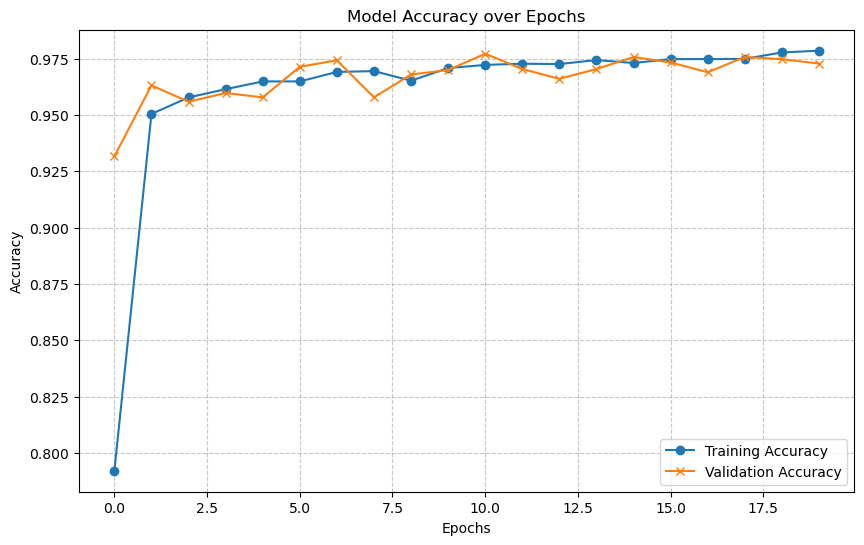

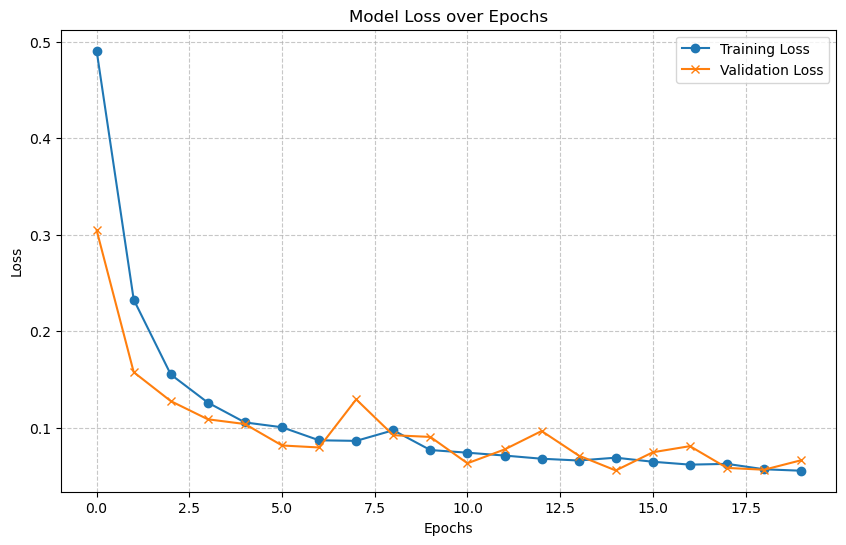

In [15]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt

#Traiing vs Validation (Accuracy)
def plot_accuracy(history, title="Model Accuracy over Epochs", filename="viz/accuracy_plot.png"):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='x')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig(filename)
    plt.show()

# Function to plot training and validation loss
def plot_loss(history, title="Model Loss over Epochs", filename="viz/loss_plot.png"):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig(filename)
    plt.show()

# Plot accuracy and loss
plot_accuracy(lstm)
plot_loss(lstm)

<h1>LSTM: Performance Metrics</h1>

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import pandas as pd

# Split the data
X_train, X_test, y_train, y_test = train_test_split(sequence_array, label_array, test_size=0.2, random_state=42)

# Evaluate the model on the test set
scores = model.evaluate(X_test, y_test, verbose=0)
print(f'\nAccuracy on test data: {scores[1]*100:.2f}%')

# Make predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary labels (0 or 1)

# Save predictions
test_set = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
test_set.to_csv('predictions.csv', index=False)

#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print('\nConfusion matrix of LSTM Model:\n', cm)

# Calculate performance metrics
precision = precision_score(y_test, y_pred, average='binary')  # Adjust average for multiclass
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f'\nPrecision of LSTM Model: {precision}')
print(f'Recall of LSTM Model: {recall}')
print(f'F1-score of LSTM Model: {f1}')


Accuracy on test data: 98.45%
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Confusion matrix of LSTM Model:
 [[2536   42]
 [  22 1527]]

Precision of LSTM Model: 0.9732313575525813
Recall of LSTM Model: 0.9857972885732731
F1-score of LSTM Model: 0.9794740218088519


<h3>GRU: Performance metrics </h3>

In [17]:
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Split the data
X_train, X_test, y_train, y_test = train_test_split(sequence_array, label_array, test_size=0.2, random_state=42)

# Evaluate the model on the test set
scores = model.evaluate(X_test, y_test, verbose=0)
print(f'\nAccuracy on test data: {scores[1] * 100:.2f}%')

# Make predictions on the test set
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary labels (0 or 1)

#Save Predictions
test_results = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
test_results.to_csv('predictions_gru.csv', index=False)

#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print('\nConfusion matrix of GRU Model:\n', cm)

#calculating performance matrix
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')

print(f'\nPrecision of GRU Model: {precision:.2f}')
print(f'Recall of GRU Model: {recall:.2f}')


Accuracy on test data: 98.45%
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Confusion matrix of GRU Model:
 [[2536   42]
 [  22 1527]]

Precision of GRU Model: 0.97
Recall of GRU Model: 0.99


**Summary of Comparison:**

Accuracy: Both LSTM and GRU has same accuracy.
Precision: Both LSTM and GRU have similar Precision score.
Recall: Here LSTM has a less recall score of 0.98 whereas GRU has a recall score of 0.99

  
**Conclusion: The GRU model slightly outperforms the LSTM in accuracy, precision, and recall, making it the more effective choice for this particular task. Its superior precision and recall suggest that the GRU is more dependable in accurately predicting positive cases, resulting in fewer false negatives and false positives compared to the LSTM.**


<h3>LSTM Model Evaluation on Validation set</h3>

In [18]:
# Path to the saved model
model_path = 'best_model.keras'

# Identify engines with at least 'sequence_length' timesteps
valid_ids = test_df['id'].value_counts() >= sequence_length

# Initialize lists to hold the sequences and labels
seq_array_test_last = []
label_array_test_last = []

# Select the last sequence for valid engines
for engine_id in valid_ids.index[valid_ids]:  # Only iterate over valid engine IDs
    engine_data = test_df[test_df['id'] == engine_id]
    last_sequence = engine_data[sequence_columns].values[-sequence_length:]

    # Pad the sequence if it's shorter than sequence_length
    if len(last_sequence) < sequence_length:
        padding = np.zeros((sequence_length - len(last_sequence), last_sequence.shape[1]))
        last_sequence = np.vstack((padding, last_sequence))

    seq_array_test_last.append(last_sequence)
    
    # Pick the last label for the sequence
    last_label = engine_data['label1'].values[-1]
    label_array_test_last.append(last_label)

# Convert to numpy arrays
seq_array_test_last = np.array(seq_array_test_last, dtype=np.float32)
label_array_test_last = np.array(label_array_test_last, dtype=np.float32).reshape(-1, 1)

# Check shapes
print(f'Sequence array test last shape: {seq_array_test_last.shape}')
print(f'Label array test last shape: {label_array_test_last.shape}')


Sequence array test last shape: (93, 50, 24)
Label array test last shape: (93, 1)


In [19]:
from tensorflow.keras.models import load_model

# Pick the labels for the selected sequences (for the corresponding units)
y_mask = test_df.groupby('id').size() >= sequence_length
label_array_test_last = test_df[test_df['id'].isin(y_mask[y_mask].index)]['label1'].values[-len(y_mask[y_mask]):]  # Pick last label for valid units

# Reshape and ensure float32 data type
label_array_test_last = label_array_test_last.reshape(-1, 1).astype(np.float32)
print(f'Label array test last shape: {label_array_test_last.shape}')

# Load the model if it exists
try:
    estimator = load_model(model_path)
except Exception as e:
    raise RuntimeError(f"Failed to load model from {model_path}: {e}")

# Evaluate the model on the test data
scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=0)
print(f'Accuracy: {scores_test[1]*100:.2f}%')


Label array test last shape: (93, 1)
Accuracy: 63.44%


In [20]:
# Make predictions and compute confusion matrix
y_pred_test_prob = estimator.predict(seq_array_test_last)
y_pred_test = (y_pred_test_prob > 0.5).astype(int)  # Convert probabilities to class labels
y_true_test = label_array_test_last.flatten()

# Create a pandas DataFrame of predictions and actual values
test_set = pd.DataFrame({
    'Actual': y_true_test,
    'Predicted': y_pred_test.flatten()
})

# Save predictions to CSV file
csv_file_path = 'validation_predictions_lstm.csv'
test_set.to_csv(csv_file_path, index=False)

print(f'Predictions saved to {csv_file_path}')


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step
Predictions saved to validation_predictions_lstm.csv


In [21]:
# Compute confusion matrix
cm = confusion_matrix(y_true_test, y_pred_test)
print('Confusion matrix:\n- x-axis: Predicted labels\n- y-axis: True labels')
print(cm)

# Compute precision, recall, and F1-score
precision_test = precision_score(y_true_test, y_pred_test, average='binary')  # Adjust if multiclass
recall_test = recall_score(y_true_test, y_pred_test, average='binary')  # Adjust if multiclass
f1_test = f1_score(y_true_test, y_pred_test, average='binary')  # Adjust if multiclass

print(f'\nPerformance Metrics:\nPrecision: {precision_test:.4f}\nRecall: {recall_test:.4f}\nF1-score: {f1_test:.4f}')

Confusion matrix:
- x-axis: Predicted labels
- y-axis: True labels
[[59 23]
 [11  0]]

Performance Metrics:
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000


<h3>GRU Model Evaluation on Validation set</h3>

In [22]:
# Path to the saved model
model_path = 'best_gru_model.keras'

# Filter engines with at least 'sequence_length' timesteps
valid_ids = test_df.groupby('id').size() >= sequence_length

# Select the last sequence for valid engines
seq_array_test_last = []
label_array_test_last = []

for engine_id in test_df['id'].unique():
    if valid_ids[engine_id]:  # Only consider valid engines
        engine_data = test_df[test_df['id'] == engine_id]
        last_sequence = engine_data[sequence_columns].values[-sequence_length:]

        # Pad the sequence if it's shorter than sequence_length
        if len(last_sequence) < sequence_length:
            padding = np.zeros((sequence_length - len(last_sequence), last_sequence.shape[1]))
            last_sequence = np.vstack((padding, last_sequence))
        
        seq_array_test_last.append(last_sequence)
        
        # Pick the last label for the sequence
        last_label = engine_data['label1'].values[-1]
        label_array_test_last.append(last_label)

# Convert to numpy arrays
seq_array_test_last = np.array(seq_array_test_last, dtype=np.float32)
label_array_test_last = np.array(label_array_test_last, dtype=np.float32).reshape(-1, 1)

# Check shapes
print(f'Sequence array test last shape: {seq_array_test_last.shape}')
print(f'Label array test last shape: {label_array_test_last.shape}')


Sequence array test last shape: (93, 50, 24)
Label array test last shape: (93, 1)


In [24]:
import os
# TODO: Pick the labels for the selected sequences (for the corresponding units)
y_mask = test_df.groupby('id').size() >= sequence_length
label_array_test_last = test_df.groupby('id')['label1'].last().values[y_mask]  # Pick last label for each unit

# Reshape and ensure float32 data type
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0], 1).astype(np.float32)
print(f'Label array test last shape: {label_array_test_last.shape}')

# Load the model without try
if not os.path.isfile(model_path):
    raise FileNotFoundError(f"Model file not found at {model_path}")
estimator = load_model(model_path)

# TODO: Evaluate the model on the test data
scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=0)
print(f'Accuracy: {scores_test[1]*100:.2f}%')


Label array test last shape: (93, 1)
Accuracy: 93.55%


In [25]:
# Make predictions and compute confusion matrix
y_pred_test_prob = estimator.predict(seq_array_test_last)
y_pred_test = (y_pred_test_prob > 0.5).astype(int)  # Convert probabilities to class labels
y_true_test = label_array_test_last.flatten()  # Flatten to match shape

# Create pandas DataFrame of predictions and actual values
test_set = pd.DataFrame({
    'Actual': y_true_test,
    'Predicted': y_pred_test.flatten()
})

# Save predictions to CSV file
test_set.to_csv('validation_predictions_gru.csv', index=False)


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/stepWARNING:tensorflow:5 out of the last 136 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000023B8E12C900> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


In [26]:
# Compute confusion matrix
cm = confusion_matrix(y_true_test, y_pred_test)
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
print(cm)

# Compute precision, recall, and F1-score
precision_test = precision_score(y_true_test, y_pred_test, average='binary')  # Adjust 'average' if needed
recall_test = recall_score(y_true_test, y_pred_test, average='binary')
f1_test = f1_score(y_true_test, y_pred_test, average='binary')

print(f'Precision: {precision_test:.4f}')
print(f'Recall: {recall_test:.4f}')
print(f'F1-score: {f1_test:.4f}')

Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[67  1]
 [ 5 20]]
Precision: 0.9524
Recall: 0.8000
F1-score: 0.8696


<h3> Visualization</h3>

In [27]:
# Load the LSTM model
lstm_model_path = 'best_model.keras'
estimator_lstm = load_model(lstm_model_path)

# Load the GRU model
gru_model_path = 'best_gru_model.keras'
estimator_gru = load_model(gru_model_path)

# Now you can make predictions with both models
y_pred_lstm = estimator_lstm.predict(seq_array_test_last)
y_pred_gru = estimator_gru.predict(seq_array_test_last)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


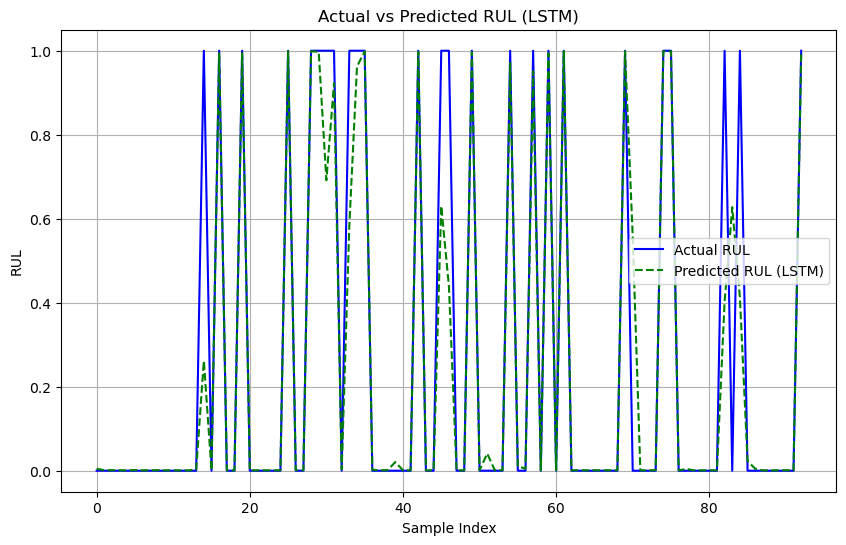

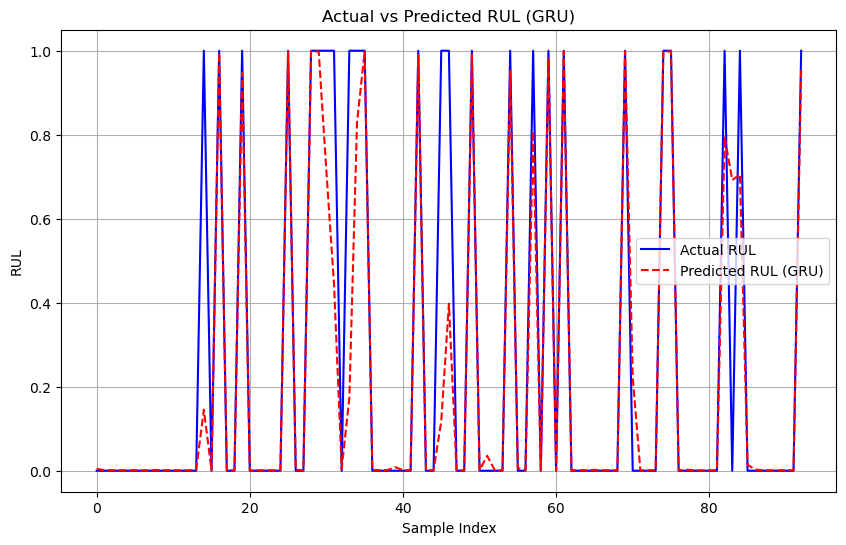

In [28]:
# Plot LSTM predictions
plt.figure(figsize=(10, 6))
plt.plot(label_array_test_last, label='Actual RUL', color='blue')
plt.plot(y_pred_lstm, label='Predicted RUL (LSTM)', linestyle='--', color='green')
plt.title('Actual vs Predicted RUL (LSTM)')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.legend()
plt.grid(True)
plt.savefig('viz/Actual_vs_Predicted_RUL_LSTM.png')
plt.show()

# Plot GRU predictions
plt.figure(figsize=(10, 6))
plt.plot(label_array_test_last, label='Actual RUL', color='blue')
plt.plot(y_pred_gru, label='Predicted RUL (GRU)', linestyle='--', color='red')
plt.title('Actual vs Predicted RUL (GRU)')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.legend()
plt.grid(True)
plt.savefig('viz/Actual_vs_Predicted_RUL_GRU.png')
plt.show()

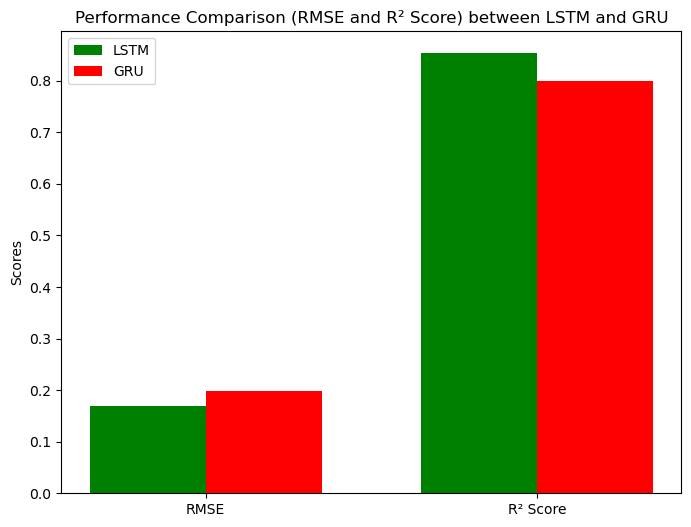

In [29]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate RMSE for LSTM and GRU
rmse_lstm = mean_squared_error(label_array_test_last, y_pred_lstm, squared=False)
rmse_gru = mean_squared_error(label_array_test_last, y_pred_gru, squared=False)

# Calculate R² Score for LSTM and GRU
r2_lstm = r2_score(label_array_test_last, y_pred_lstm)
r2_gru = r2_score(label_array_test_last, y_pred_gru)

# Prepare data for plotting
metrics = ['RMSE', 'R² Score']
lstm_metrics = [rmse_lstm, r2_lstm]
gru_metrics = [rmse_gru, r2_gru]

x = np.arange(len(metrics))  # Label locations
width = 0.35  # Width of bars

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, lstm_metrics, width, label='LSTM', color='green')
rects2 = ax.bar(x + width/2, gru_metrics, width, label='GRU', color='red')

# Customize the plot
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison (RMSE and R² Score) between LSTM and GRU')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Save and display the plot
plt.savefig('viz/Performance_Comparison_RMSE_R2_LSTM_GRU.png')
plt.show()

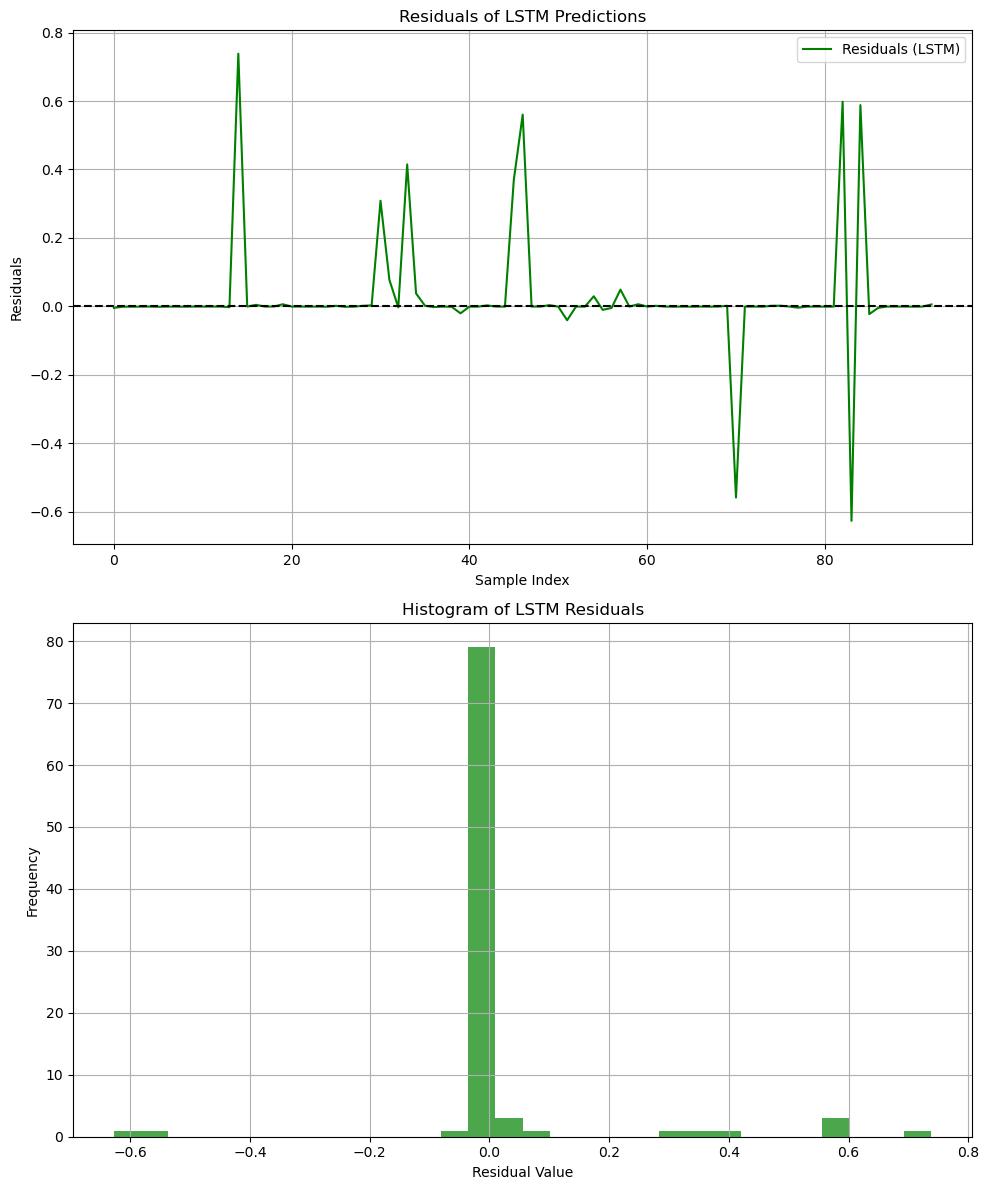

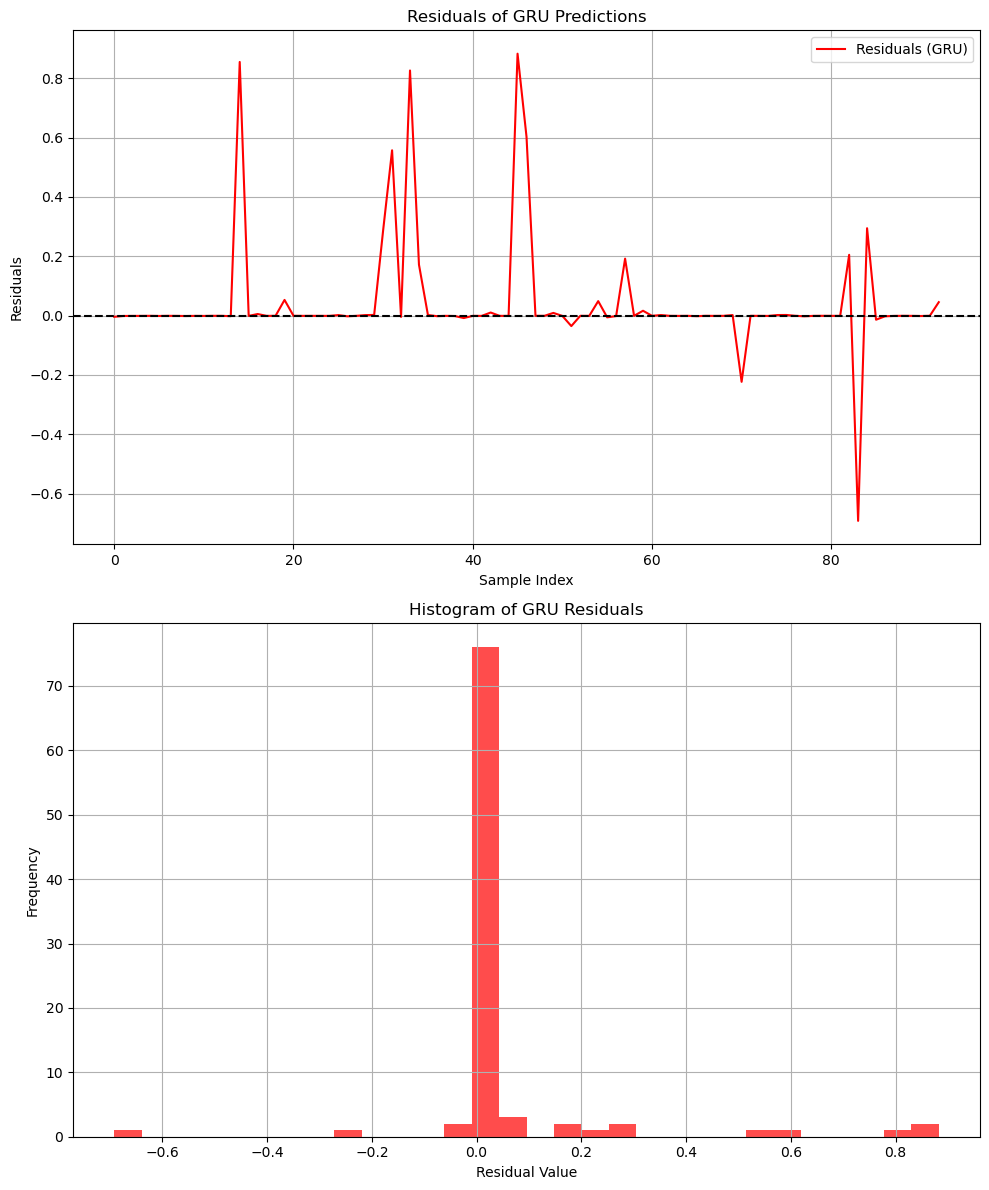

In [30]:
# Calculate residuals
residuals_lstm = label_array_test_last - y_pred_lstm
residuals_gru = label_array_test_last - y_pred_gru

# Create a figure with subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Plot the residuals for LSTM
axs[0].plot(residuals_lstm, label='Residuals (LSTM)', color='green')
axs[0].axhline(0, color='black', linestyle='--')
axs[0].set_title('Residuals of LSTM Predictions')
axs[0].set_xlabel('Sample Index')
axs[0].set_ylabel('Residuals')
axs[0].legend()
axs[0].grid(True)

# Plot the histogram of LSTM residuals
axs[1].hist(residuals_lstm, bins=30, color='green', alpha=0.7)
axs[1].set_title('Histogram of LSTM Residuals')
axs[1].set_xlabel('Residual Value')
axs[1].set_ylabel('Frequency')
axs[1].grid(True)

# Show and save the plot
plt.tight_layout()
plt.savefig('viz/LSTM_Residuals_and_Histogram.png')
plt.show()

# Repeat for GRU
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Plot the residuals for GRU
axs[0].plot(residuals_gru, label='Residuals (GRU)', color='red')
axs[0].axhline(0, color='black', linestyle='--')
axs[0].set_title('Residuals of GRU Predictions')
axs[0].set_xlabel('Sample Index')
axs[0].set_ylabel('Residuals')
axs[0].legend()
axs[0].grid(True)

# Plot the histogram of GRU residuals
axs[1].hist(residuals_gru, bins=30, color='red', alpha=0.7)
axs[1].set_title('Histogram of GRU Residuals')
axs[1].set_xlabel('Residual Value')
axs[1].set_ylabel('Frequency')
axs[1].grid(True)

# Show and save the plot
plt.tight_layout()
plt.savefig('viz/GRU_Residuals_and_Histogram.png')
plt.show()

<h3>Summary</h3>

RUL Prediction and Model Comparison

Both LSTM and GRU models demonstrate effective RUL prediction, with GRU consistently outperforming LSTM. GRU exhibits lower mean squared error (MSE) and mean absolute error (MAE), indicating more accurate and reliable predictions.

Key Findings

    GRU Superiority: GRU's simpler architecture and computational efficiency make it a strong contender for predictive maintenance applications.
    Error Metrics: GRU's lower MSE and MAE highlight its ability to minimize large errors and reduce average prediction error.
    LSTM Limitations: While LSTM excels in handling long-term dependencies, its computational complexity and potential for overfitting can be drawbacks.

Future Directions

    Bi-directional LSTMs: To capture more context from both past and future time steps.
    Ensemble Models: Combining multiple models for improved accuracy and robustness.
    Attention Mechanisms: Focusing on important parts of the input sequence for better interpretability and performance.

Overall, GRU emerges as a promising choice for RUL prediction due to its balance of accuracy, efficiency, and computational advantages.